In [1]:
from collections         import namedtuple
import json

import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd

from slugify import slugify

In [2]:
Dist = namedtuple('Requests', ['raw', 'cdf'])


class Adblocker:
    def __init__(self, filename, color, label):
        self.label = label
        self.color = color
        self._raw = self.load_data(filename)
        
        self.cacheSize = self._raw['cacheSize']
        self.parsingTime = self._raw['parsingTime']

        serializationTimings = self._raw.get('serializationTimings')
        if serializationTimings:
            self.serializationTimings = Dist(
                raw=serializationTimings, 
                cdf=self.generateCDF(serializationTimings)
            )
            
        deserializationTimings = self._raw.get('deserializationTimings')
        if deserializationTimings:
            self.deserializationTimings = Dist(
                raw=deserializationTimings, 
                cdf=self.generateCDF(deserializationTimings)
            )


        # data
        self.blocked = Dist(raw=self._raw['matches'], cdf=self.generateCDF(self._raw['matches']))
        self.not_blocked = Dist(raw=self._raw['noMatches'], cdf=self.generateCDF(self._raw['noMatches']))
        self.all = Dist(raw=self._raw['all'], cdf=self.generateCDF(self._raw['all']))

    
    @staticmethod
    def load_data(filename):
        with open(filename, 'r') as f:
            return json.load(f)

    @staticmethod
    def generateCDF(array):
        cdf_attrs = namedtuple('cdf_attrs', ['cdf', 'bin_edges'])

        data_size=len(array)

        # Set bins edges
        data_set=sorted(set(array))
        bins=np.append(data_set, data_set[-1]+1)

        # Use the histogram function to bin the data
        counts, bin_edges = np.histogram(array, bins=bins, density=False)
        counts = counts.astype(float) / data_size

        # Find the cdf
        _cdf = np.cumsum(counts)

        return cdf_attrs(cdf=_cdf, bin_edges=bin_edges)

In [3]:
brave    = Adblocker(filename='data/brave_timings.json', color='#ff5500', label='Brave')
ghostery = Adblocker(filename='data/ghostery_timings.json', color='#00aff0', label='Ghostery')
ublock   = Adblocker(filename='data/ublock_timings.json', color='#800000', label='uBlock Origin')
duck     = Adblocker(filename='data/duckduckgo_timings.json', color='#58b792', label='DuckDuckGo')
abp      = Adblocker(filename='data/adblockplus_timings.json', color='#c70d2c', label='Adblock Plus')

In [4]:
def compare(*args, attr='match', log_x=False, log_y=False, xlim=None, save=True, y_label='Fraction of Requests', title=None):
    fig, ax = plt.subplots()
    
    for a in args:
        _attr = getattr(a, attr)
        ax.plot(_attr.cdf.bin_edges[0:-1], _attr.cdf.cdf, linestyle='--', linewidth=2, color=a.color, label=a.label)
        
    # Plot the cdf
    ax.grid(linestyle='--', linewidth=1)
    if xlim:
        ax.set_xlim(*xlim)
    ax.legend(loc='lower right')
    plt.tight_layout(pad=3)
    if log_x:
        plt.xscale('log')
        plt.xlabel("Time (ms) \n log (base 10)")
    else:
        plt.xlabel("Time (ms)")
    if log_y:
        plt.yscale('log')
        plt.ylabel(f"{y_label} \n log (base 10)")
    else:
        plt.ylabel(y_label)

    if title is not None:
        plt.title(title)

    if save:
        filename = slugify(f'{"-".join(map(lambda x: x.label, args))}-{attr}')
        fig.savefig(f'plots/{filename}.svg')
    plt.show()

In [5]:
def pie(*args, save=True):    

    match = []
    no_match = []

    for a in args:
        match.append(len(a.blocked.raw))
        no_match.append(len(a.not_blocked.raw))

    sizes = [np.mean(match), np.mean(no_match)]
    labels = ['Blocked', 'Not Blocked']
    colors = ['#ff9999','#91c5f5']
    explode = (0.05, 0.05)
    plt.pie(sizes, colors=colors, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode)

    #draw circle
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    # Equal aspect ratio ensures that pie is drawn as a circle
    plt.axis('equal')  
    plt.tight_layout()
    plt.title('Proportion of Blocked Requests')
    plt.show()
    fig.savefig('plots/requests-composition.svg')

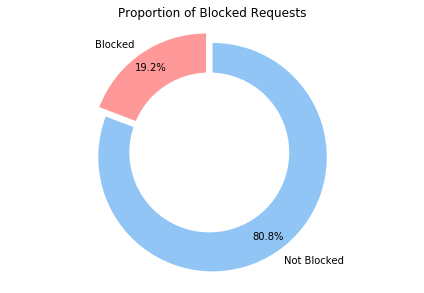

In [6]:
pie(ghostery, ublock, duck, brave, abp)

### **Looking at all requests**

#### 1. **Ghostery vs uBlock**

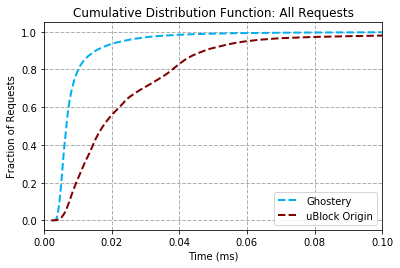

In [7]:
compare(ghostery, ublock, attr="all", log_x=False, log_y=False, xlim=(0, 0.10), title='Cumulative Distribution Function: All Requests')

### **Ghostery vs uBlock vs Brave**

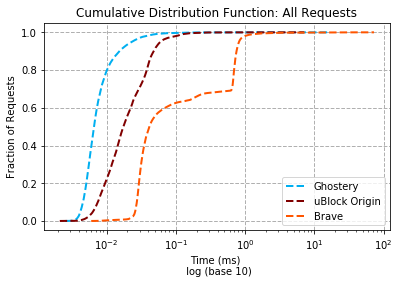

In [8]:
compare(ghostery, ublock, brave, attr="all", log_x=True, log_y=False, title='Cumulative Distribution Function: All Requests')

### **Ghostery vs AdblockPlus**

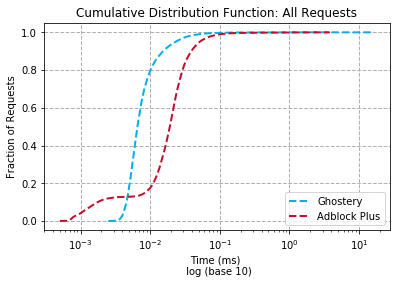

In [9]:
compare(ghostery, abp, attr="all", log_x=True, log_y=False, title='Cumulative Distribution Function: All Requests')

### **Ghostery vs AdblockPlus vs uBlock Origin**

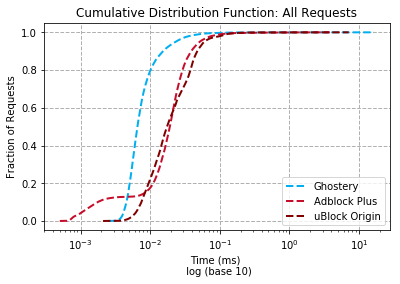

In [10]:
compare(ghostery, abp, ublock, attr="all", log_x=True, log_y=False, title='Cumulative Distribution Function: All Requests')

### **Ghostery vs uBlock vs Brave vs DuckDuckGo**

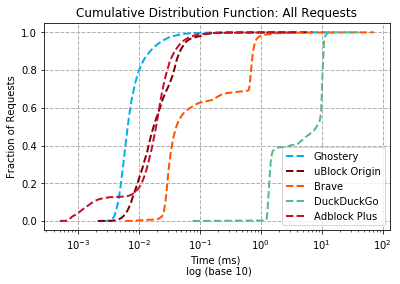

In [11]:
compare(ghostery, ublock, brave, duck, abp, attr="all", log_x=True, log_y=False, title='Cumulative Distribution Function: All Requests')

### **Ghostery vs uBlock vs Brave vs AdblockPlus**

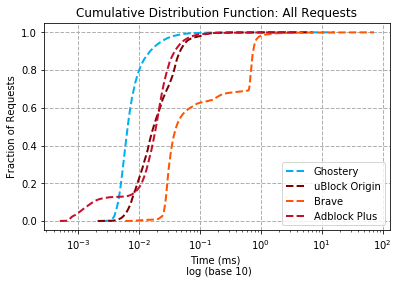

In [12]:
compare(ghostery, ublock, brave, abp, attr="all", log_x=True, log_y=False, title='Cumulative Distribution Function: All Requests')

### **Ghostery vs uBlock vs AdblockPlus**

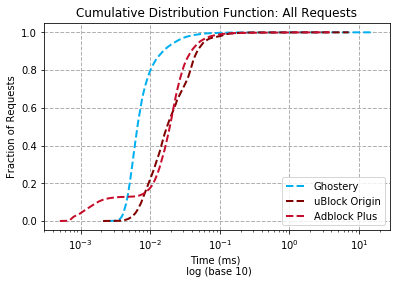

In [13]:
compare(ghostery, ublock, abp, attr="all", log_x=True, log_y=False, title='Cumulative Distribution Function: All Requests')

### **What happens where there is a match**

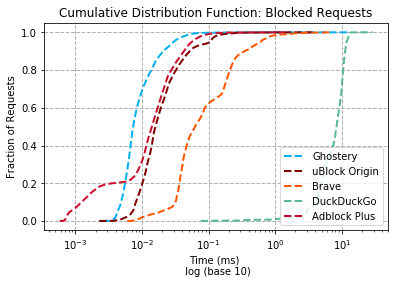

In [14]:
compare(ghostery, ublock, brave, duck, abp, attr="blocked", log_x=True, log_y=False, title='Cumulative Distribution Function: Blocked Requests')

### **What happens where there is NO match**

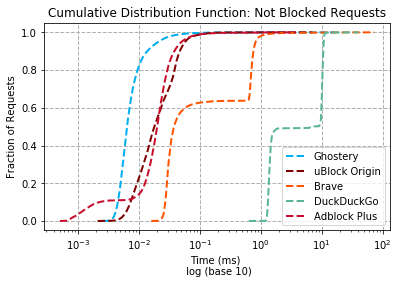

In [15]:
compare(ghostery, ublock, brave, duck, abp, attr="not_blocked", log_x=True, log_y=False, title='Cumulative Distribution Function: Not Blocked Requests')

### Memory

### 99th percentile

In [16]:
def get_99p(adblocker):
    return [
        adblocker.all.cdf.bin_edges[len([x for x in adblocker.all.cdf.cdf if x < 0.99])],
        adblocker.not_blocked.cdf.bin_edges[len([x for x in adblocker.not_blocked.cdf.cdf if x < 0.99])],
        adblocker.blocked.cdf.bin_edges[len([x for x in adblocker.blocked.cdf.cdf if x < 0.99])],
    ]

p99 = pd.DataFrame({
    'request_type': ['_all', 'not_blocked', 'blocked'],
    'ghostery': get_99p(ghostery),
    'ublock': get_99p(ublock),
    'brave': get_99p(brave),
    'duck': get_99p(duck),
    'abp': get_99p(abp),
})

p99['ublock_vs_ghostery'] = p99.ublock / p99.ghostery
p99['brave_vs_ghostery'] = p99.brave / p99.ghostery
p99['duck_vs_ghostery'] = p99.duck / p99.ghostery
p99['abp_vs_ghostery'] = p99.abp / p99.ghostery

In [17]:
p99

,request_type,ghostery,ublock,brave,duck,abp,ublock_vs_ghostery,brave_vs_ghostery,duck_vs_ghostery,abp_vs_ghostery
0,_all,0.049825,0.124101,1.288046,12.084761,0.103083,2.490738,25.851400,242.544124,2.068901
1,not_blocked,0.048555,0.111508,1.269874,11.189538,0.105098,2.296530,26.153311,230.450788,2.164514
2,blocked,0.052412,0.164751,1.468203,13.024691,0.098532,3.143383,28.012726,248.505896,1.879951


### Medians

In [18]:
medians = pd.DataFrame({
    'request_type': ['_all', 'not_blocked', 'blocked'],
    'ghostery': list(map(lambda x: np.median(x), [ghostery.all.raw, ghostery.not_blocked.raw, ghostery.blocked.raw])),
    'ublock': list(map(lambda x: np.median(x), [ublock.all.raw, ublock.not_blocked.raw, ublock.blocked.raw])),
    'brave': list(map(lambda x: np.median(x), [brave.all.raw, brave.not_blocked.raw, brave.blocked.raw])),
    'duck': list(map(lambda x: np.median(x), [duck.all.raw, duck.not_blocked.raw, duck.blocked.raw])),
    'abp': list(map(lambda x: np.median(x), [abp.all.raw, abp.not_blocked.raw, abp.blocked.raw]))

})


In [19]:
medians['ublock_vs_ghostery'] = medians.ublock / medians.ghostery
medians['brave_vs_ghostery'] = medians.brave / medians.ghostery
medians['duck_vs_ghostery'] = medians.duck / medians.ghostery
medians['abp_vs_ghostery'] = medians.abp / medians.ghostery

In [20]:
medians

,request_type,ghostery,ublock,brave,duck,abp,ublock_vs_ghostery,brave_vs_ghostery,duck_vs_ghostery,abp_vs_ghostery
0,_all,0.006572,0.017472,0.041328,8.270044,0.019164,2.658551,6.288497,1258.375533,2.916007
1,not_blocked,0.006394,0.017992,0.037838,6.780612,0.020016,2.813888,5.917735,1060.464811,3.130435
2,blocked,0.007350,0.015901,0.062427,8.309739,0.014033,2.163469,8.493469,1130.576803,1.909252


In [21]:
list(medians.request_type)

['_all', 'not_blocked', 'blocked']

In [22]:
float(medians.ghostery[
    (medians.request_type == 'not_blocked' )
])

def generate_table(request_type):
    tables = {
        '99': p99,
        'median': medians,
    }
    
    args = {}
    blockers = ['ghostery', 'ublock', 'abp', 'brave', 'duck']
    for name in blockers:
        for kind in ['median', '99']:
            table = tables[kind]
            args[f'{name}_{kind}'] = round(float(table[name][table.request_type == request_type]), 3)
            for vs in blockers:
                if vs != 'ghostery':
                    args[f'vs_{vs}_{kind}'] = round(float(table[f'{vs}_vs_ghostery'][table.request_type == request_type]), 1)


    return """
|               | 99% OF REQUESTS             | MEDIAN                       |
| ------------- | --------------------------- | ---------------------------- |
| **Ghostery**  | **{ghostery_99}ms**                 | **{ghostery_median}ms**                  |
| uBlock Origin | {ublock_99}ms (**{vs_ublock_99}x slower**)   | {ublock_median}ms (**{vs_ublock_median}x slower**)    |
| Adblock Plus  | {abp_99}ms (**{vs_abp_99}x slower**)   | {abp_median}ms (**{vs_abp_median}x slower**)     |
| Brave         | {brave_99}ms (**{vs_brave_99}x slower**)  | {brave_median}ms (**{vs_brave_median}x slower**)    |
| DuckDuckGo    | {duck_99}ms (**{vs_duck_99}x slower**) | {duck_median}ms (**{vs_duck_median}x slower**) |
    """.format(**args)

for request_type in ['_all', 'not_blocked', 'blocked']:
    print('Request type', request_type)
    print(generate_table(request_type=request_type))

Request type _all

|               | 99% OF REQUESTS             | MEDIAN                       |
| ------------- | --------------------------- | ---------------------------- |
| **Ghostery**  | **0.05ms**                 | **0.007ms**                  |
| uBlock Origin | 0.124ms (**2.5x slower**)   | 0.017ms (**2.7x slower**)    |
| Adblock Plus  | 0.103ms (**2.1x slower**)   | 0.019ms (**2.9x slower**)     |
| Brave         | 1.288ms (**25.9x slower**)  | 0.041ms (**6.3x slower**)    |
| DuckDuckGo    | 12.085ms (**242.5x slower**) | 8.27ms (**1258.4x slower**) |
    
Request type not_blocked

|               | 99% OF REQUESTS             | MEDIAN                       |
| ------------- | --------------------------- | ---------------------------- |
| **Ghostery**  | **0.049ms**                 | **0.006ms**                  |
| uBlock Origin | 0.112ms (**2.3x slower**)   | 0.018ms (**2.8x slower**)    |
| Adblock Plus  | 0.105ms (**2.2x slower**)   | 0.02ms (**3.1x slower**)     |
| 

## Serialization and Deserialization timings

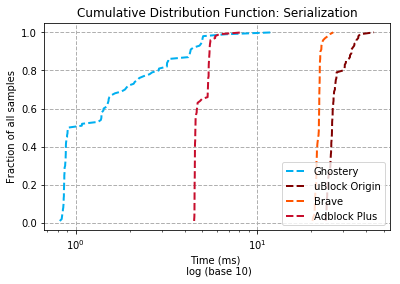

In [23]:
compare(ghostery, ublock, brave, abp, attr="serializationTimings", log_x=True, log_y=False, y_label="Fraction of all samples", title='Cumulative Distribution Function: Serialization')

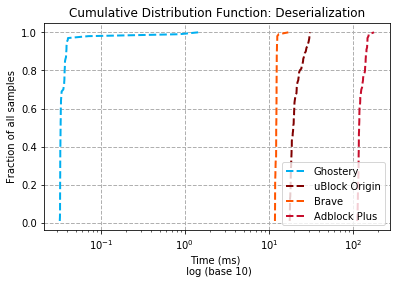

In [24]:
compare(ghostery, ublock, brave, abp, attr="deserializationTimings", log_x=True, log_y=False, y_label="Fraction of all samples", title='Cumulative Distribution Function: Deserialization')

In [25]:
# simplified bar plot of medians

In [26]:
def compute_loading_medians(field, *adblockers):
    return pd.DataFrame({
        'adblocker': [adblocker.label for adblocker in adblockers],
        field: [np.median(getattr(adblocker, field).raw) for adblocker in adblockers],
    })

In [27]:
def barplot(df, metric, ylabel, color, save=True, title=None):
    if title is None:
        title = metric.title()
    fig, ax = plt.subplots()
    plt.bar(x = df.adblocker, height=df[metric], width=0.5, color=color)
            
    # Plot the cdf
    ax.grid(linestyle='--', linewidth=1)

    plt.tight_layout(pad=3)
    plt.ylabel(ylabel)
    plt.title(title)
    if save:
        fig.savefig(f'plots/{slugify(metric)}.svg')
    plt.show()

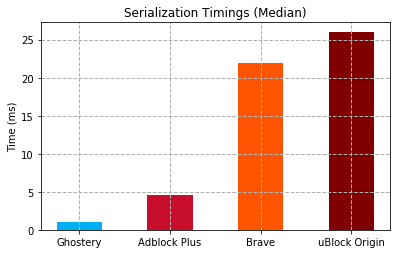

In [28]:
serialization_medians = compute_loading_medians('serializationTimings', ghostery, abp, brave, ublock)
barplot(
    serialization_medians, 
    'serializationTimings',
    title='Serialization Timings (Median)',
    ylabel="Time (ms)", 
    color=[ghostery.color, abp.color, brave.color, ublock.color], 
    save=True
)

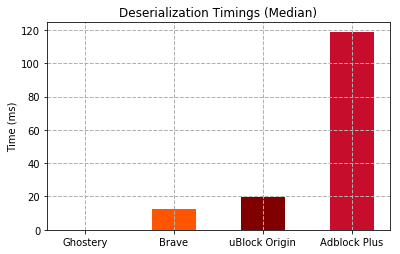

In [29]:
deserialization_medians = compute_loading_medians('deserializationTimings', ghostery, brave, ublock, abp)
barplot( 
    deserialization_medians, 
    'deserializationTimings', 
    ylabel="Time (ms)",
    title='Deserialization Timings (Median)',
    color=[ghostery.color, brave.color, ublock.color, abp.color], 
    save=True
)

In [30]:
deserialization_medians

,adblocker,deserializationTimings
0,Ghostery,0.033173
1,Brave,12.231583
2,uBlock Origin,19.521571
3,Adblock Plus,118.616674


In [31]:
19.521571 / 0.033173

588.4777077743948

## Serialized Size

In [32]:
size_medians = pd.DataFrame({
    'adblocker': [abp.label, ghostery.label, brave.label, ublock.label],
    'Cache Size': [abp.cacheSize, ghostery.cacheSize, brave.cacheSize, ublock.cacheSize]
})

size_medians['Cache Size'] /= (10**6)

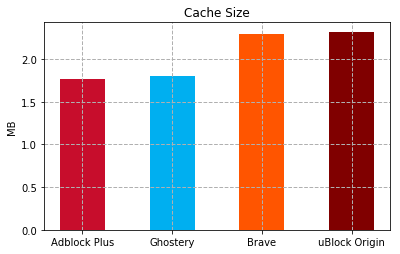

In [33]:
barplot(
    size_medians, 
    'Cache Size', 
    ylabel="MB", 
    color=[abp.color, ghostery.color, brave.color, ublock.color], 
    save=True
)

### Memory Usage

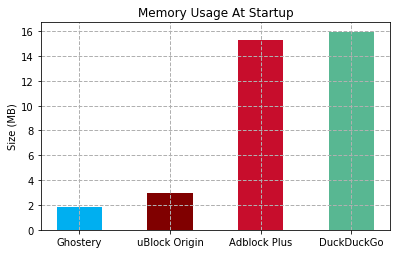

In [34]:
memory_medians = pd.DataFrame({
    'adblocker': [ghostery.label, ublock.label, abp.label, duck.label],
    'Memory Usage at startup': [1.803, 2.942, 15.292, 15.920]
})


barplot(
    memory_medians, 
    'Memory Usage at startup', 
    ylabel="Size (MB)", 
    color=[ghostery.color, ublock.color, abp.color, duck.color], 
    save=True
)

### Time to Parse Lists

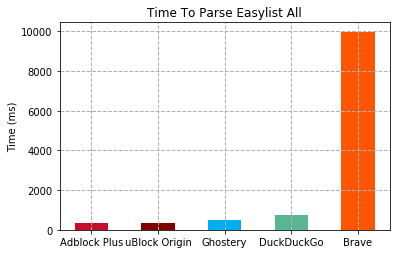

In [35]:
time2parse_medians = pd.DataFrame({
    'adblocker': [abp.label, ublock.label, ghostery.label, duck.label, brave.label],
    'Time to parse Easylist All': [abp.parsingTime, ublock.parsingTime, ghostery.parsingTime, duck.parsingTime, brave.parsingTime]
})

barplot(
    time2parse_medians, 
    'Time to parse Easylist All', 
    ylabel="Time (ms)", 
    color=[abp.color, ublock.color, ghostery.color, duck.color, brave.color], 
    save=True
)

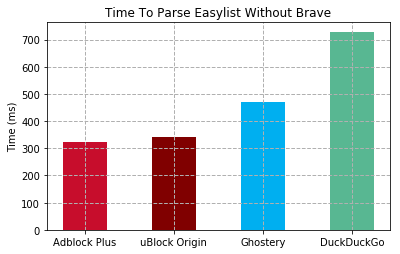

In [36]:
time2parse_medians = pd.DataFrame({
    'adblocker': [abp.label, ublock.label, ghostery.label, duck.label],
    'Time to parse Easylist Without Brave': [abp.parsingTime, ublock.parsingTime, ghostery.parsingTime, duck.parsingTime]
})

barplot(
    time2parse_medians, 
    'Time to parse Easylist Without Brave', 
    ylabel="Time (ms)", 
    color=[abp.color, ublock.color, ghostery.color, duck.color], 
    save=True
)